In [2]:
!pip install langchain-google-genai==1.0.4 --progress-bar off
!pip install langgraph==0.0.23
!pip install tavily-python
!pip install duckduckgo-search
!pip -qqq install langchain-groq==0.1.3 --progress-bar off
!pip install langgraph langchain_community==0.0.29 --progress-bar off

  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.6
    Uninstalling google-ai-generativelanguage-0.6.6:
      Successfully uninstalled google-ai-generativelanguage-0.6.6
  Attempting uninstall: google-generativeai
    Found existing installation: google-generativeai 0.7.2
    Uninstalling google-generativeai-0.7.2:
      Successfully uninstalled google-generativeai-0.7.2


In [38]:
import os
from google.colab import userdata
os.environ["GROQ_API_KEY"]=userdata.get("GROQ_API_KEY")
from langchain_groq import ChatGroq
llm = ChatGroq(temperature=0, model_name="llama3-70b-8192")

In [39]:
result=llm.invoke("What is the capital of Telangana?")
result.content

'The capital of Telangana is Hyderabad.'

In [40]:
from langgraph.graph import StateGraph,END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults

In [41]:
os.environ['TAVILY_API_KEY']=userdata.get('TAVILY_API_KEY')

In [42]:
tool = TavilySearchResults(max_results=4)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


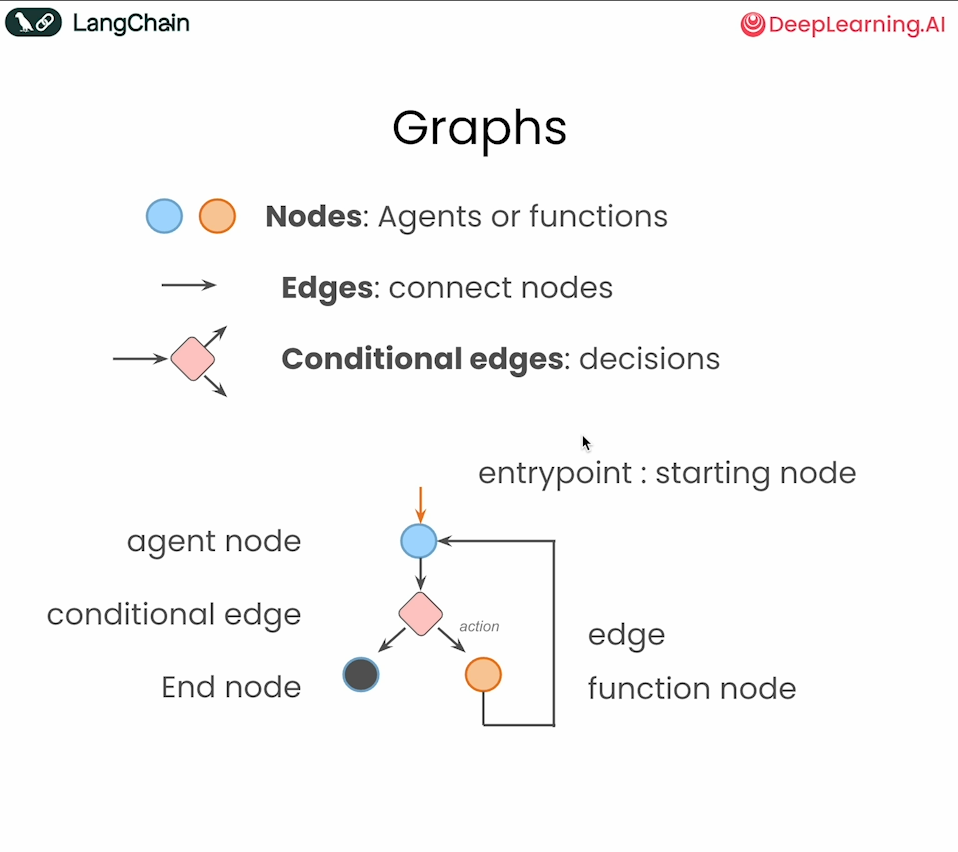

In [63]:
class AgentState(TypedDict):
  messages:Annotated[list[AnyMessage],operator.add]

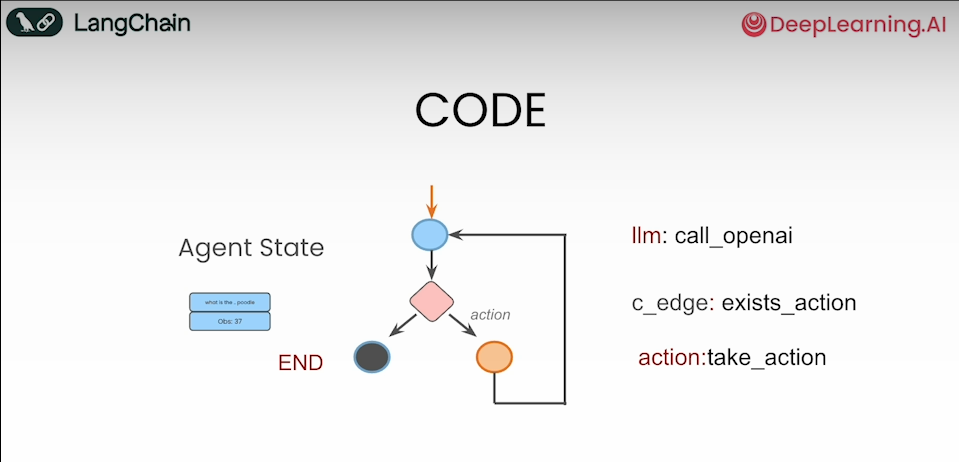

In [80]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [84]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

In [85]:
abot=Agent(llm,[tool],system=prompt)

In [86]:
messages = [HumanMessage(content="What is the weather in hyderabad?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in hyderabad'}, 'id': 'call_q5s0'}
Back to the model!


In [87]:
result

{'messages': [HumanMessage(content='What is the weather in hyderabad?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_q5s0', 'function': {'arguments': '{"query":"current weather in hyderabad"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 1015, 'total_tokens': 1066, 'completion_time': 0.155668283, 'prompt_time': 0.052372504, 'queue_time': 0.004332152999999998, 'total_time': 0.208040787}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2f30b0b571', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d7ee1499-2ff0-4c0b-81e8-46ea36eb2d5d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in hyderabad'}, 'id': 'call_q5s0'}]),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Hyderabad\', \'region\': \'Andhra Pradesh\', \'country\': \'India\', \'lat\': 17.375

In [88]:
result['messages'][-1].content

'The current weather in Hyderabad is 24.4°C (75.9°F) with a condition of Mist.'

In [89]:
messages = [HumanMessage(content="What is the population of telangana and Kerala?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'population of telangana'}, 'id': 'call_yz5h'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'population of kerala'}, 'id': 'call_xnwr'}
Back to the model!


In [90]:
result['messages'][-1].content

'The population of Telangana is 350 lakhs (or 3.5 crores) and the population of Kerala is approximately 35.82 million (or 3.58 crores) as of 2023.'

In [91]:
messages = [HumanMessage(content="Which has won ISL 2023 and Is capital for which state?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'ISL 2023 winner'}, 'id': 'call_wayx'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'capital of which state is ATK Mohun Bagan'}, 'id': 'call_1c6a'}
Back to the model!


In [92]:
result['messages'][-1].content

'ATK Mohun Bagan is based in Kolkata, West Bengal.'

In [93]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_pgbn'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_10nr'}
Back to the model!


In [94]:
result['messages'][-1].content

'The weather in San Francisco is partly cloudy with a temperature of 55°F (12.8°C) and humidity of 86%. The wind is blowing at 6.5 mph (10.4 kph) from the WSW direction.\n\nThe weather in Los Angeles is sunny with a temperature of 79°F (26.1°C) and humidity of 23%. The wind is blowing at 2.7 mph (4.3 kph) from the SSW direction.'